In [23]:
import os
import cv2
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


import torchvision
import torchvision.transforms as transforms

sys.path.append('../')
from models.vit import *

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [3]:
epochs = 10
batch_size = 32
momentum = 0.9
lr = 0.0002
weight_decay = 1e-4
num_classes = 10
img_size = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_workers = os.cpu_count()
saved = '../saved/cifar_net_64.pth'
pretrained = '../saved/cifar_vit_32_v2.pth'


In [4]:
train_transforms = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.ColorJitter(0.1,0.1,0.1,0.1),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0), ratio=(0.75, 1.25)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transforms = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
train_dataset = torchvision.datasets.CIFAR10('../dataset', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10('../dataset', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
images, targets = next(iter(train_loader))
images.shape, targets

(torch.Size([32, 3, 64, 64]),
 tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
         2, 4, 0, 7, 5, 1, 8, 6]))

In [8]:
model_args = dict(img_size=img_size, 
                  patch_size=8, 
                  embed_dim=192, 
                  depth=12, 
                  num_heads=2, 
                  checkpoint=pretrained, 
                  qk_norm=True, 
                  v_norm=True, 
                  patch_stride=4)
model =  vit_small_patch8_32(**model_args)

load pretrained from ../saved/cifar_vit_32_v2.pth


In [9]:
out = model(images)
out.shape

torch.Size([32, 10])

In [10]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


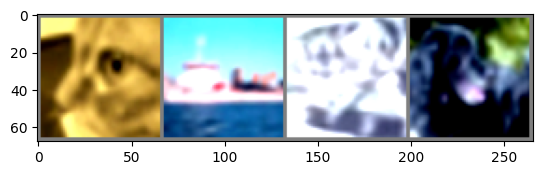

In [12]:
imshow(torchvision.utils.make_grid(images[:4]))

In [13]:

criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
scheduler = None

model = model.to(device)

In [14]:
from utils.train import get_acc

In [15]:
best_acc = 0.
val_acc_list = []
for epoch in (range(epochs)):
    running_loss = []
    model.train()
    for i, data in (enumerate(train_loader)):
        images, targets = data
        images, targets = images.to(device), targets.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    test_acc = get_acc(test_loader, model, device)
    val_acc_list.append(test_acc)
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), saved)

    lr = optimizer.param_groups[0]['lr']
    print(f'{epoch + 1} loss: {sum(running_loss)/len(running_loss):.3f} acc: {test_acc:.2f} lr: {lr:.5f}')
    if scheduler :
        scheduler.step()


1 loss: 0.525 acc: 87.01 lr: 0.00020
2 loss: 0.386 acc: 87.75 lr: 0.00020
3 loss: 0.349 acc: 87.26 lr: 0.00020
4 loss: 0.320 acc: 87.73 lr: 0.00020
5 loss: 0.300 acc: 88.91 lr: 0.00020
6 loss: 0.286 acc: 87.96 lr: 0.00020
7 loss: 0.273 acc: 87.82 lr: 0.00020
8 loss: 0.262 acc: 88.73 lr: 0.00020
9 loss: 0.253 acc: 89.10 lr: 0.00020
10 loss: 0.238 acc: 88.31 lr: 0.00020


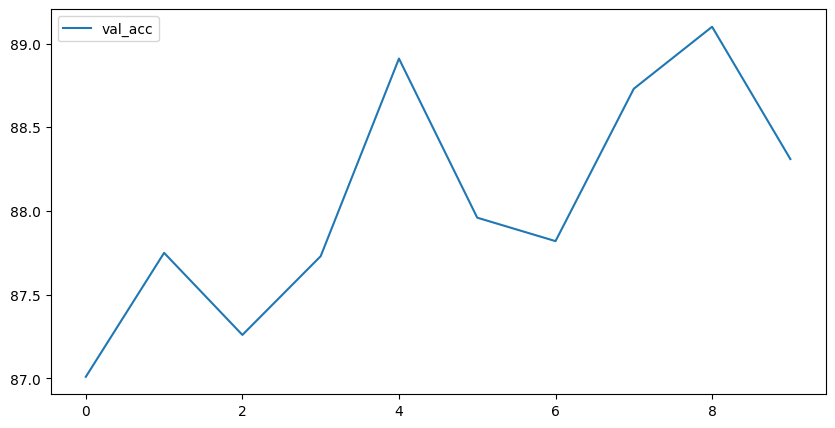

In [16]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,5]
plt.plot(val_acc_list, label='val_acc')
plt.legend()


In [17]:
from utils.train import get_all_preds
test_preds = get_all_preds(model.to('cpu'), test_loader)
actual_labels = torch.Tensor(test_dataset.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

total correct: 8831
accuracy: 0.8831


Confusion matrix, without normalization
[[934  13  15   4   7   0   5   1  14   7]
 [  9 964   2   2   0   0   0   0   3  20]
 [ 26   5 890  18  29  14  11   2   2   3]
 [ 15   5  48 737  43 100  33  12   2   5]
 [  7   1  32   9 918   5  14  13   1   0]
 [  8   3  21  86  31 825  13  10   0   3]
 [  5   1  34   9  20   4 922   4   0   1]
 [  5   2  19  18  68  29   0 859   0   0]
 [ 65  25   7   0   0   1   2   1 885  14]
 [ 10  77   3   7   0   0   0   2   4 897]]


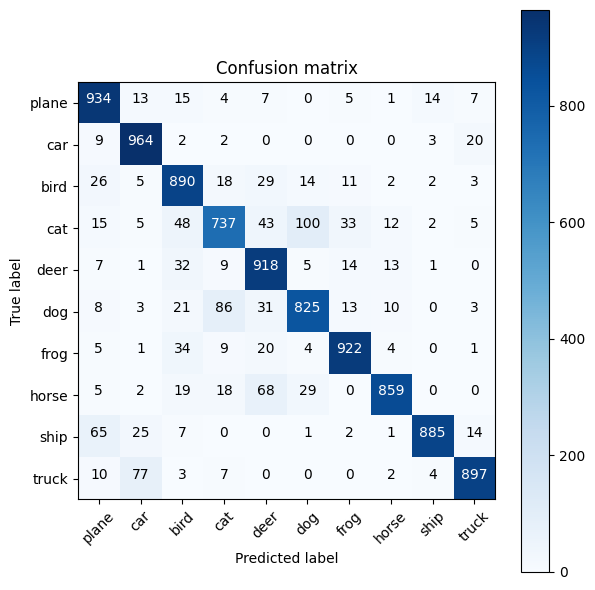

In [18]:
from utils.visualize import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes)

In [26]:
img_size

64

In [41]:
img_size = 64
vis_transforms = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

torch.Size([1, 3, 64, 64])


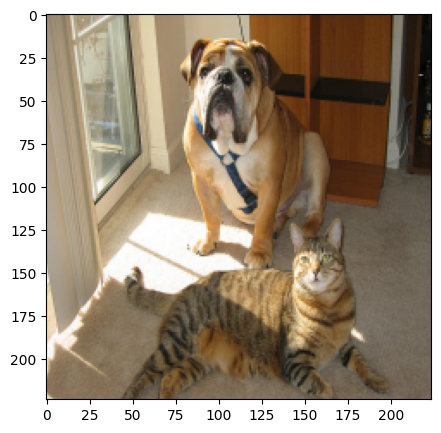

In [51]:

from utils.visualize import VITAttentionRollout, show_mask_on_image
discard_ratio = 0.98
head_fusion = 'max'
img = Image.open('../example/dog_cat.png')
img = img.resize((224, 224))
input_tensor = vis_transforms(img).unsqueeze(0).to(device)
print(input_tensor.shape)
model.to(device)

attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
            discard_ratio=discard_ratio)
mask = attention_rollout(input_tensor)
name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)


np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
plt.imshow(img)
plt.show()


In [52]:
mask.shape

(224, 224, 3)

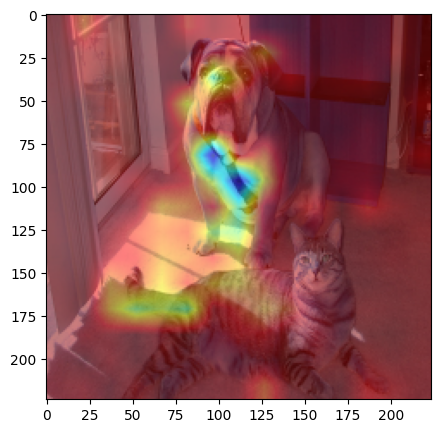

In [53]:
plt.imshow(mask)
plt.show()

torch.Size([1, 3, 64, 64])


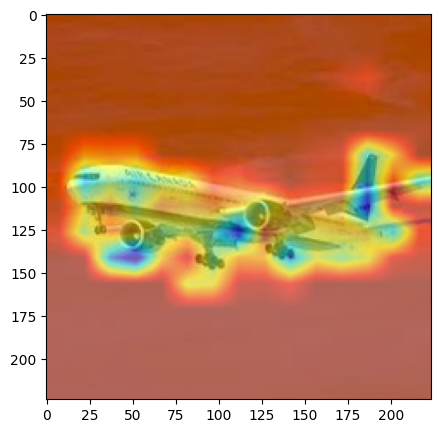

In [55]:
from utils.visualize import VITAttentionRollout, show_mask_on_image
discard_ratio = 0.98
head_fusion = 'max'
img = Image.open('../example/plane.jpeg')
img = img.resize((224, 224))
input_tensor = vis_transforms(img).unsqueeze(0).to(device)
print(input_tensor.shape)
model.to(device)

attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
            discard_ratio=discard_ratio)
mask = attention_rollout(input_tensor)
name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)


np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
plt.imshow(mask)
plt.show()